### Ookla Internet Speeds
Internet test results. For some reason all the markers are shapefile polygons, squares of a uniform size, for some reason?

#### Notes:
- I need to represent density, chlororpleth maps would be nice
- I want the average values for each feature, basically in a quadrant by quadrant chloropleth map

### TODO:
- clustering out and replotting
- folium heatmap
- median speeds and latency in major area? using the shapefiles from boundaries?
- Folium Chloropleth map?
- Clustering algorithms?
- is there enough data to determine if someone is underserved?

In [52]:
import geopandas as gpd
import pandas as pd

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium
from folium.plugins import HeatMap

In [2]:
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc(
#     "axes",
#     labelweight="bold",
#     labelsize="large",
#     titleweight="bold",
#     titlesize=14,
#     titlepad=10,
# )

In [3]:
ls ../data/ookla

AB_ookla_data_2020.cpg  AB_ookla_data_2020.prj  AB_ookla_data_2020.shx
AB_ookla_data_2020.dbf  AB_ookla_data_2020.shp


In [4]:
gdf = gpd.read_file("../data/ookla/AB_ookla_data_2020.shp")

In [5]:
gdf.shape

(122047, 9)

In [6]:
gdf.head()

quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices  \
0  0212113033010133         807         273          84      1        1   
1  0212113123020220       82062       11294          19     34        4   
2  0212131212333013        9741        1382          24      7        2   
3  0213002023012223       81989       39432          13     56        7   
4  0212113301112020        4405        2300          37      3        1   

  quarter conn_type                                           geometry  
0      Q1     fixed  POLYGON ((-114.13147 53.53051, -114.12598 53.5...  
1      Q1     fixed  POLYGON ((-113.55469 53.46843, -113.54919 53.4...  
2      Q1     fixed  POLYGON ((-114.28528 51.20344, -114.27979 51.2...  
3      Q1     fixed  POLYGON ((-112.05505 53.49131, -112.04956 53.4...  
4      Q1     fixed  POLYGON ((-113.29102 53.29806, -113.28552 53.2...

In [7]:
# replace polygons with

In [8]:
gdf["quadkey"].value_counts().shape

(47763,)

In [9]:
gdf.shape

(122047, 9)

### K-n Clustering
- its very hard to tell what the clustering is on
- spatial join is sjoin

In [10]:
gdf["long"] = gdf.geometry.apply(lambda x:x.centroid.x)

In [11]:
gdf["lat"] = gdf.geometry.apply(lambda x:x.centroid.y)

In [12]:
gdf[["long", "lat"]].head()

long        lat
0 -114.128723  53.528881
1 -113.551941  53.466796
2 -114.282532  51.201721
3 -112.052307  53.489680
4 -113.288269  53.296414

In [13]:
df = pd.DataFrame(gdf[["avg_d_kbps", "long", "lat"]]); df.head()

avg_d_kbps        long        lat
0         807 -114.128723  53.528881
1       82062 -113.551941  53.466796
2        9741 -114.282532  51.201721
3       81989 -112.052307  53.489680
4        4405 -113.288269  53.296414

In [14]:
X = df.copy()

In [15]:
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

avg_d_kbps        long        lat Cluster
0         807 -114.128723  53.528881       0
1       82062 -113.551941  53.466796       4
2        9741 -114.282532  51.201721       0
3       81989 -112.052307  53.489680       4
4        4405 -113.288269  53.296414       0

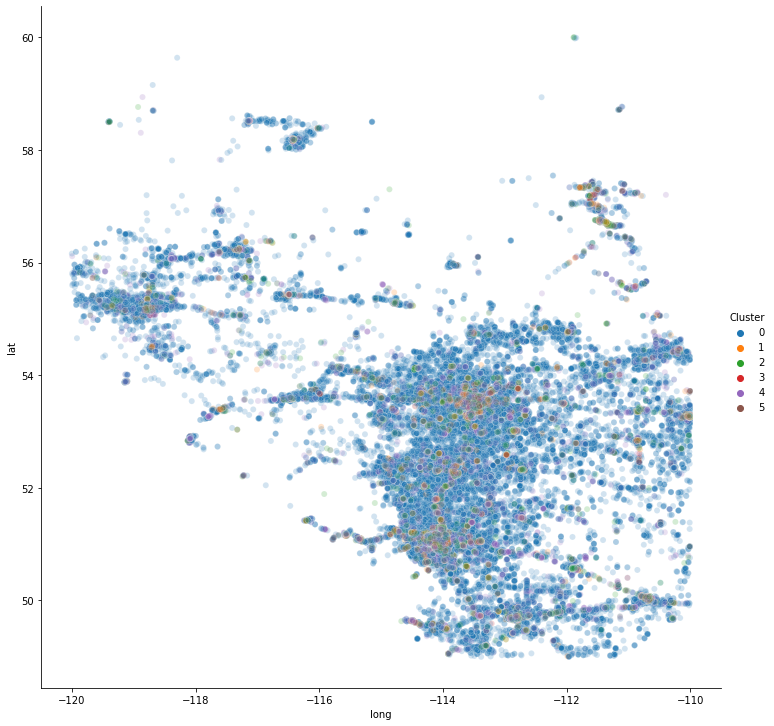

In [45]:
sns.relplot(
    x="long", y="lat", hue="Cluster", data=X, height=10, alpha=0.2
);

In [17]:
X.head()

avg_d_kbps        long        lat Cluster
0         807 -114.128723  53.528881       0
1       82062 -113.551941  53.466796       4
2        9741 -114.282532  51.201721       0
3       81989 -112.052307  53.489680       4
4        4405 -113.288269  53.296414       0

In [19]:
# turn back in gdf
cluster_gdf = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X["long"], X["lat"] ))
cluster_gdf.crs = {"init":"epsg:4326"}

/home/peter/anaconda3/envs/basic-data/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [43]:
size = (24, 30)
lwidth=2

In [38]:
plt.subplots?

<AxesSubplot:>

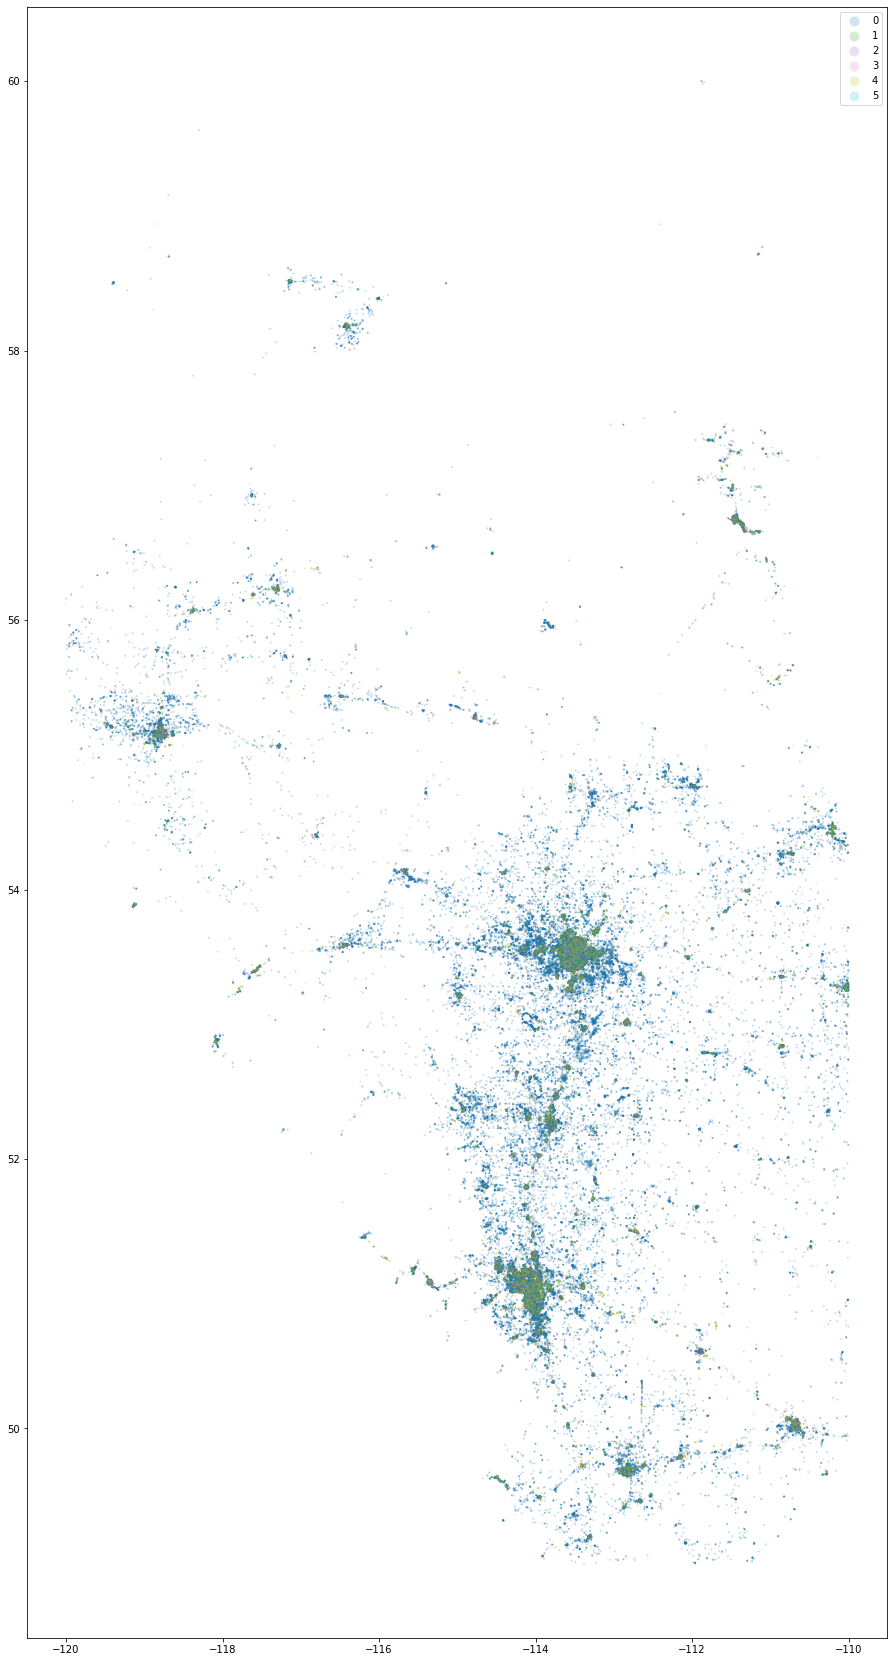

In [46]:
fig, ax = plt.subplots(1, 1, figsize=size)
cluster_gdf.plot(figsize=size, column="Cluster", markersize=1, alpha=0.2, ax=ax, legend=True)

### Folium Heatmap using Clustering Categories

Not as many features in this dataset. This one is also cleaned.

In [55]:
X.head(2)

avg_d_kbps        long        lat Cluster                     geometry
0         807 -114.128723  53.528881       0  POINT (-114.12872 53.52888)
1       82062 -113.551941  53.466796       4  POINT (-113.55194 53.46680)

In [84]:
HeatMap?

In [91]:
# Create a base map
#f = folium.Figure(width=650, height=1000)
m_1 = folium.Map(location=[55,-115], tiles='cartodbpositron', zoom_start=5, width="60%", height="100%")

# Add a heatmap to the base map
HeatMap(data=X[['lat', 'long', "avg_d_kbps"]], name="Internet Download Speeds", radius=6).add_to(m_1)

# Display the map
m_1